# Imports

In [120]:
import torch
from torch import optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2 as cv
import os
import sys

In [ ]:
# Adiciona o diretório pai (raiz do projeto) ao path do sistema
sys.path.append(os.path.abspath(".."))

# ativar autoreload -> capturar mudanças do código fonte
%load_ext autoreload
%autoreload 2

from src.dataset import Vocabulary, FlickrDataset, build_glove_matrix, preprocess_data
from src.trainer import ImageCaptionTrainer
from src.model import ImageCaptionModel, ScratchGRU, PreTrainedMobileNetV3, ScratchRNN, PreTrainedResNet50
from src.tester import ImageCaptionTester

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocess Data

## Data Splitting

In [78]:
# Split by unique image ids
df = pd.read_csv("../data/cleaned/flickr8k_cleaned_data.csv")
unique_images = df['image'].unique()

# Primeiro split: Treino vs Resto (Validação + Teste)
train_ids, temp_ids = train_test_split(unique_images, test_size=0.15, random_state=42)
# Segundo split: Divide o resto entre Validação e Teste
val_ids, test_ids = train_test_split(temp_ids, test_size=0.075, random_state=42)

train_df = df[df['image'].isin(train_ids)].reset_index(drop=True)
val_df = df[df['image'].isin(val_ids)].reset_index(drop=True)
test_df = df[df['image'].isin(test_ids)].reset_index(drop=True)

test_grouped = test_df.groupby('image')['caption_clean'].apply(list).reset_index()

## Vocabulary and Dataloaders

In [79]:
train_captions = train_df['caption_clean'].tolist()

min_freq=1

vocab = Vocabulary(min_freq)
vocab.build_vocabulary(train_captions)

In [80]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),         
    # Média e desvio padrão para cada canal de cor do imagenet
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

batch_size = 128
max_tokens = 100
image_path = "../data/raw/Images"

train_dataset = FlickrDataset(image_path, train_df, vocab, transform=transform, max_tokens=max_tokens)
val_dataset = FlickrDataset(image_path, val_df, vocab, transform=transform, max_tokens=max_tokens)
test_dataset = FlickrDataset(image_path, test_grouped, vocab, transform=transform, max_tokens=max_tokens, is_eval=True)

train_loader, val_loader, test_loader = preprocess_data(train_dataset, val_dataset, test_dataset, batch_size)

test_loader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=0
)

# Model Setup

In [81]:
# Model Configuration -> Ainda vamos mudar aqui
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 1
DROPOUT = 0.5
EPOCHS = 25
PATIENCE = 5
LEARNING_RATE = 3e-4
CLIP_NORM=5.0



In [82]:
# CNN Encoder (MobileNetV3)
encoder = PreTrainedMobileNetV3(
    dropout_rate=DROPOUT, 
    embed_size=EMBED_SIZE, 
    fine_tune=True
)

# RNN Decoder (GRU)
decoder = ScratchRNN(
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT,
    vocab=vocab,
    is_gru=False
)

model = ImageCaptionModel(cnn=encoder, rnn=decoder)

# Training

In [83]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"], reduction="mean")

trainer = ImageCaptionTrainer(
    model=model, 
    optimizer=optimizer, 
    device=device,
    loss_function=loss_fn, 
    clip_norm=CLIP_NORM
)

Training is beginning with device: cuda


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epochs:  96%|█████████▌| 24/25 [11:02<00:27, 27.60s/it, Train Loss=1.9193, Val Loss=2.8302, Patience=5/5]



Early stopping triggered at epoch 25


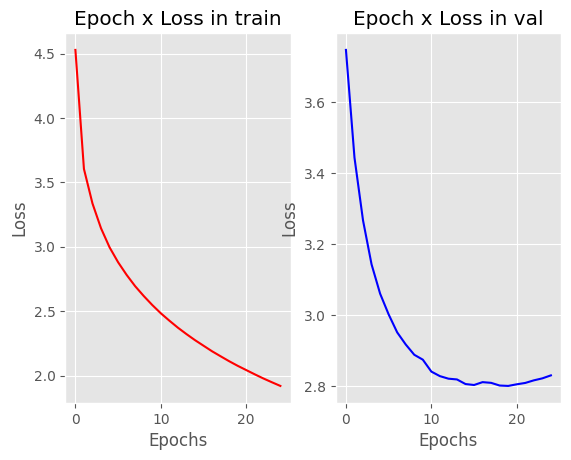

In [84]:
# Start training with Early Stopping

trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=EPOCHS, 
    patience=PATIENCE,
    epsilon=1e-3,
    checkpoint_dir='../checkpoints'
)

# Evaluation

In [104]:
checkpoint = torch.load('../checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Move o modelo inteiro para o device (GPU ou CPU)
model.to(device) 
model.eval()

tester = ImageCaptionTester(model, device, vocab)
resultados = tester.test(test_loader)

print("\n--- Final Metrics ---")
for metric, score in resultados.items():
    print(f"{metric}: {score:.4f}")

hyperparameters = {
    "EMBED_SIZE": EMBED_SIZE,
    "HIDDEN_SIZE": HIDDEN_SIZE,
    "NUM_LAYERS": NUM_LAYERS,
    "DROPOUT": DROPOUT,
    "EPOCHS": EPOCHS,
    "PATIENCE": PATIENCE,
    "LEARNING_RATE": LEARNING_RATE,
    "CLIP_NORM": CLIP_NORM
}

metrics = resultados

tester.write_log_txt(hyperparameters, resultados, "../checkpoints/")

Evaluating:  80%|████████  | 74/92 [00:00<00:00, 79.25it/s]

Evaluating: 100%|██████████| 92/92 [00:01<00:00, 74.96it/s]


{'testlen': 913, 'reflen': 911, 'guess': [913, 821, 729, 637], 'correct': [552, 253, 102, 40]}
ratio: 1.0021953896805684

--- Final Metrics ---
Bleu_1: 0.6046
Bleu_2: 0.4316
Bleu_3: 0.2965
Bleu_4: 0.2011
Meteor: 0.2106
Cider: 0.6551


In [133]:
image_files = test_df["image_path"]
image_idx = 10
image_path = image_files[image_idx].split("/")
image_literal_path = "../data/raw/Images/" + image_path[-1]


In [137]:
tester.show_example(transform, image_literal_path)

AttributeError: module 'PIL.Image' has no attribute 'Open'